#### Model v2 -- to run code below I had to switch into a different virtual environment and install just these packages

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import numpy as np
from skimage.filters import gabor_kernel
import copy
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import copy
import datetime
import modeling

## do 16 16 
### do percent change in accuracy instead of accuracy differences 

In [ ]:
transform_cifar = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 64

## Load CIFAR-10 dataset (training = 50,000 images, test = 10,000 images)

cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)
cifar_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)
cifar_trainset, cifar_valset = random_split(cifar_trainset, [int(len(cifar_trainset) * 0.9), int(len(cifar_trainset) * 0.1)])
cifar_train_loader = DataLoader(cifar_trainset, batch_size=batch_size, shuffle=True)    # shape = (40000, 1, 32, 32)
cifar_val_loader = DataLoader(cifar_valset, batch_size=batch_size, shuffle=False)
cifar_test_loader = DataLoader(cifar_testset, batch_size=batch_size, shuffle=False)

# gabor_trainset = modeling.GaborDataset(num_images=45000, img_size=32, orientations=10, frequencies=[0.08, 0.04], add_noise=True, noise_level=0.1)
# gabor_valset = modeling.GaborDataset(num_images=5000, img_size=32, orientations=10, frequencies=[0.08, 0.04], add_noise=True, noise_level=0.1)
# gabor_testset = modeling.GaborDataset(num_images=10000, img_size=32, orientations=10, frequencies=[0.08, 0.04], add_noise=True, noise_level=0.1)
gabor_trainset = modeling.GaborDatasetNoisy(
    num_images=45000,
    img_size=32,
    orientations=10,
    frequencies=[0.08, 0.04],
    noise_level=0.2,
    orientation_jitter=0.15,
    frequency_jitter=0.015,
    sigma_range=(8, 22),
    offset_jitter=7,
    seed=1,
)
gabor_valset = modeling.GaborDatasetNoisy(
    num_images=5000,
    img_size=32,
    orientations=10,
    frequencies=[0.08, 0.04],
    noise_level=0.2,
    orientation_jitter=0.15,
    frequency_jitter=0.015,
    sigma_range=(8, 22),
    offset_jitter=7,
    seed=2,
)
gabor_testset = modeling.GaborDatasetNoisy(
    num_images=10000,
    img_size=32,
    orientations=10,
    frequencies=[0.08, 0.04],
    noise_level=0.2,
    orientation_jitter=0.15,
    frequency_jitter=0.015,
    sigma_range=(8, 22),
    offset_jitter=7,
    seed=3,
)
gabor_train_loader = DataLoader(gabor_trainset, batch_size=batch_size, shuffle=True)
gabor_val_loader = DataLoader(gabor_valset, batch_size=batch_size, shuffle=False)
gabor_test_loader = DataLoader(gabor_testset, batch_size=batch_size, shuffle=False)

assert len(cifar_trainset) + len(cifar_valset) == 50000
assert len(gabor_trainset) == len(cifar_trainset)
assert len(gabor_valset) == len(cifar_valset)
assert len(gabor_testset) == len(cifar_testset)

combined_trainset = ConcatDataset([cifar_trainset, gabor_trainset])
combined_loader = DataLoader(combined_trainset, batch_size=batch_size, shuffle=True)
combined_valset = ConcatDataset([cifar_valset, gabor_valset])
combined_val_loader = DataLoader(combined_valset, batch_size=batch_size, shuffle=True) # need to shuffle val set too because of concatdataset

Files already downloaded and verified
Files already downloaded and verified


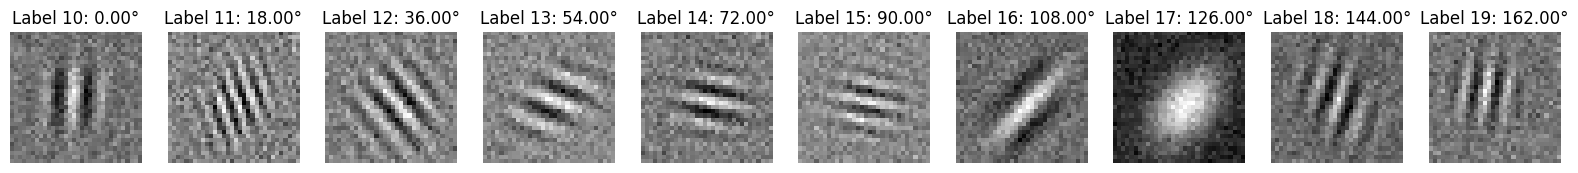

In [59]:
fig, axs = plt.subplots(1, 10, figsize=(20, 5))
orientations = np.linspace(0, np.pi, 10, endpoint=False)
orientations_deg = orientations * 180 / np.pi
gabor_valset = modeling.GaborDatasetNoisy(
    num_images=10,
    img_size=32,
    orientations=10,
    frequencies=[0.08, 0.04],
    noise_level=0.15,
    orientation_jitter=0.1,
    frequency_jitter=0.015,
    sigma_range=(8, 22),
    offset_jitter=5,
    seed=43,
)

for i in range(10):
    axs[i].imshow(gabor_valset[i][0].squeeze(), cmap='gray')
    axs[i].set_title(f'Label {gabor_valset[i][1]}: {orientations_deg[gabor_valset[i][1] - 10]:.2f}°')
    axs[i].axis('off')



In [60]:
model = modeling.ConvNet(in_channels=1, height=32, width=32)
model, train_losses, val_losses, train_losses_epoch, val_losses_epoch, gabor_vals, cifar_vals = modeling.train_model(
    model, 
    train_loader=combined_loader,
    batch_size=64,
    probe_size=64,
    val_dataset=combined_valset,
    num_epochs=50,
    early_stopping=True,
    )

Training model with tag: 2025_10_17_21:12:10


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6184Validation Loss: 4.6174


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 1.9819Validation Loss: 2.1276


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.7307Validation Loss: 1.9904


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6002Validation Loss: 1.9779


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.4926Validation Loss: 1.9816


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.3889Validation Loss: 1.9765


Batches in epoch #7:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [7/50]Training Loss: 1.2872Validation Loss: 2.0146
Early stopping triggered: validation loss increased significantly 2.0146 -> 2.0744.


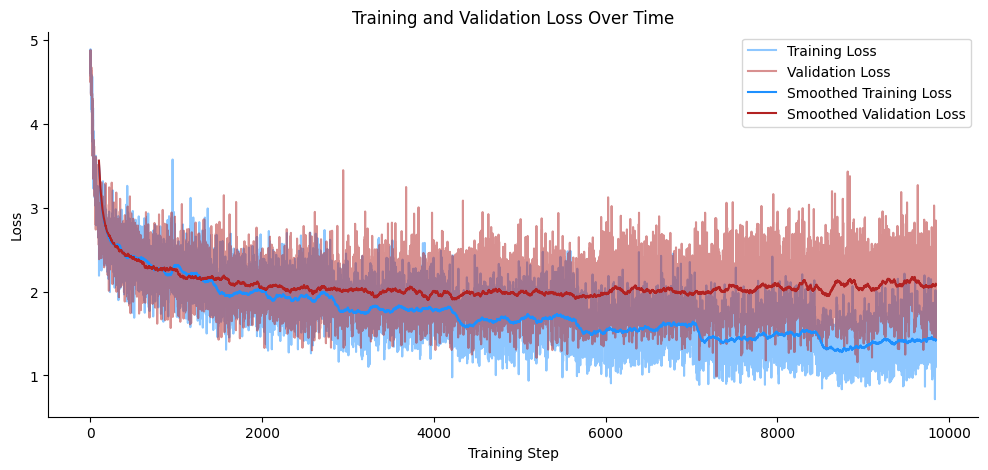

In [61]:
fig, axs = plt.subplots(1, 1, figsize=(12, 5))
axs.plot(train_losses, label="Training Loss", color='dodgerblue', alpha=0.5)
axs.plot(val_losses, label="Validation Loss", color='firebrick', alpha=0.5)

# plot smoothed losses
window_size = 100
train_losses_smooth = np.convolve(train_losses, np.ones(window_size)/window_size, mode='valid')
val_losses_smooth = np.convolve(val_losses, np.ones(window_size)/window_size, mode='valid')
axs.plot(range(window_size - 1, len(train_losses)), train_losses_smooth, label="Smoothed Training Loss", color='dodgerblue')
axs.plot(range(window_size - 1, len(val_losses)), val_losses_smooth, label="Smoothed Validation Loss", color='firebrick')
axs.set_xlabel("Training Step")
axs.set_ylabel("Loss")
axs.set_title("Training and Validation Loss Over Time")
axs.legend()
# axs.set_xlim(0, 10000)
plt.gca().spines[['top', 'right']].set_visible(False)


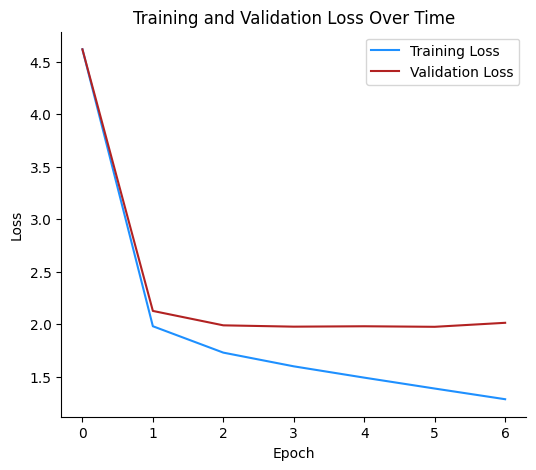

In [64]:
fig, axs = plt.subplots(1, 1, figsize=(6, 5))
axs.plot(train_losses_epoch, label="Training Loss", color='dodgerblue')
axs.plot(val_losses_epoch[:-1], label="Validation Loss", color='firebrick')

axs.set_xlabel("Epoch")
axs.set_ylabel("Loss")
axs.set_title("Training and Validation Loss Over Time")
axs.legend()
# axs.set_xlim(0, 10000)
plt.gca().spines[['top', 'right']].set_visible(False)


Text(0.5, 1.0, 'Validation Accuracy over Epochs')

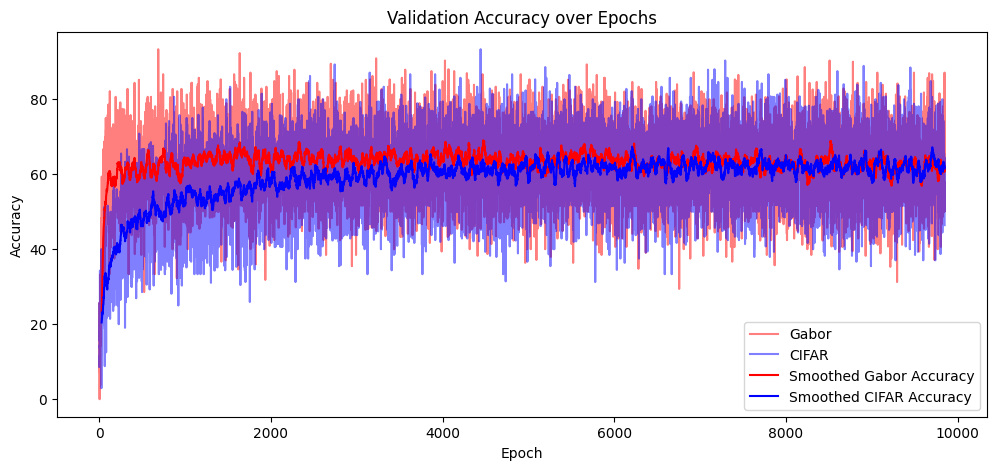

In [65]:
plt.figure(figsize=(12, 5))

plt.plot(gabor_vals, label='Gabor', color='red', alpha=0.5)
plt.plot(cifar_vals, label='CIFAR', color='blue', alpha=0.5)

# plot smoothed accuracies
window_size = 30
gabor_vals_smooth = np.convolve(gabor_vals, np.ones(window_size)/window_size, mode='valid')
plt.plot(range(window_size - 1, len(gabor_vals)), gabor_vals_smooth, label="Smoothed Gabor Accuracy", color='red')
cifar_vals_smooth = np.convolve(cifar_vals, np.ones(window_size)/window_size, mode='valid')
plt.plot(range(window_size - 1, len(cifar_vals)), cifar_vals_smooth, label="Smoothed CIFAR Accuracy", color='blue')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
# plt.xlim(-10, 200)
plt.title('Validation Accuracy over Epochs')

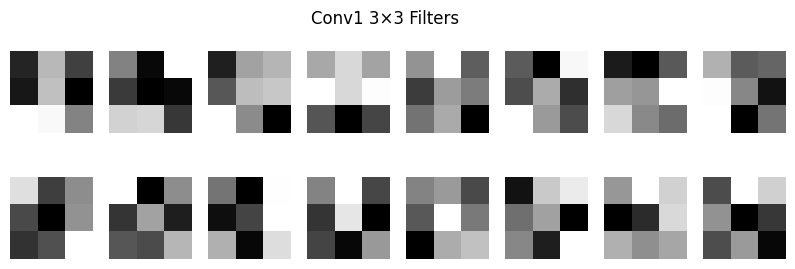

In [49]:
weights = model.conv1.weight.data.cpu().numpy()  # (16, 1, 3, 3)
fig, axes = plt.subplots(2, 8, figsize=(10, 3))
for i, ax in enumerate(axes.flat):
    kernel = weights[i, 0, :, :]  # take the 3x3 filter for channel 0
    ax.imshow(kernel, cmap="gray")
    ax.axis("off")
plt.suptitle("Conv1 3×3 Filters")
plt.show()

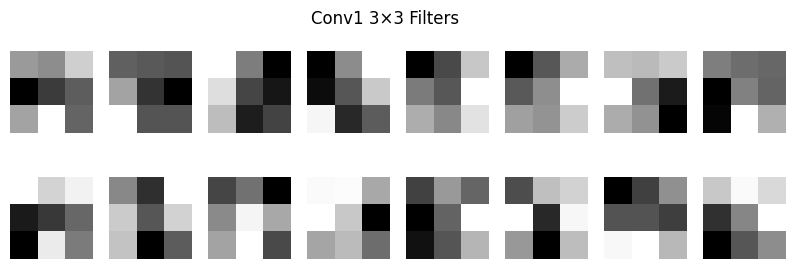

In [50]:
weights = model.conv2.weight.data.cpu().numpy()  # (16, 1, 3, 3)
fig, axes = plt.subplots(2, 8, figsize=(10, 3))
for i, ax in enumerate(axes.flat):
    kernel = weights[i, 0, :, :]  # take the 3x3 filter for channel 0
    ax.imshow(kernel, cmap="gray")
    ax.axis("off")
plt.suptitle("Conv1 3×3 Filters")
plt.show()

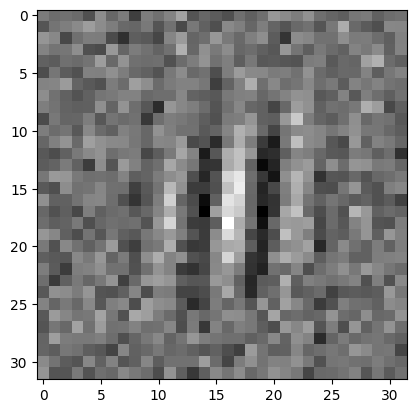

In [51]:
input_example = gabor_trainset[0][0].to('cuda')
# input_example = cifar_trainset[3][0].to('cuda')

plt.imshow(input_example[0, :, :].cpu(), cmap="gray")

Text(0.5, 0.98, 'Conv1 Feature Maps (Activations)')

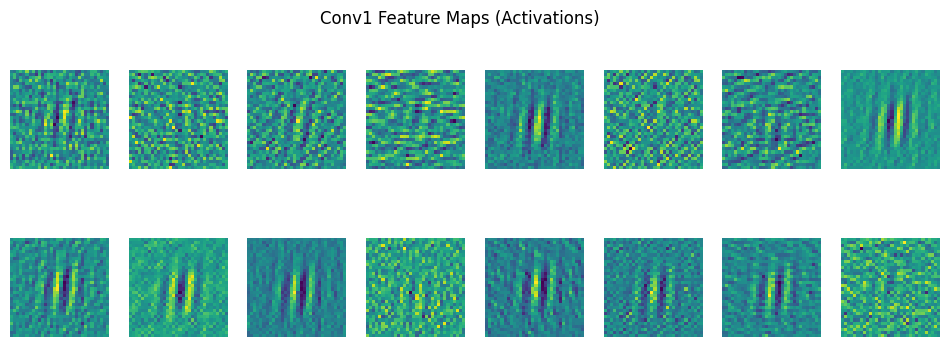

In [52]:

with torch.no_grad():
    output = model.conv1(input_example).to('cpu')
# Visualize each feature map
fig, axes = plt.subplots(2, 8, figsize=(12, 4))
for i, ax in enumerate(axes.flat):
    fmap = output[i, :, :]
    ax.imshow(fmap, cmap="viridis")
    ax.axis("off")
plt.suptitle("Conv1 Feature Maps (Activations)")

Text(0.5, 0.98, 'Conv2 Feature Maps (Activations)')

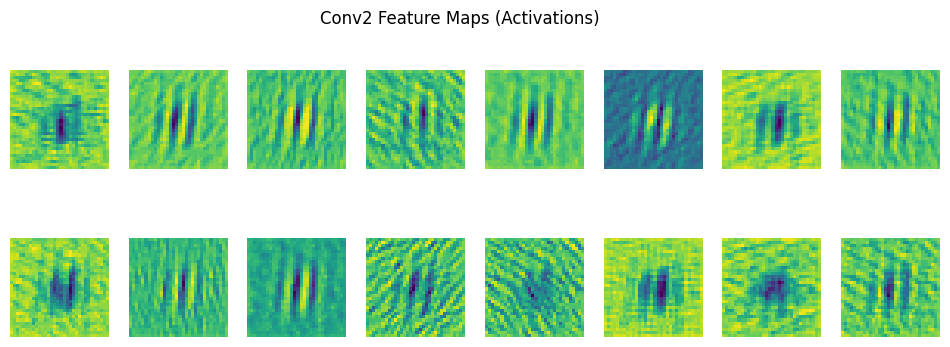

In [53]:
with torch.no_grad():
    output = model.relu(model.conv1(input_example))
    output = model.conv2(output).to('cpu')
    
# Visualize each feature map
fig, axes = plt.subplots(2, 8, figsize=(12, 4))
for i, ax in enumerate(axes.flat):
    fmap = output[i, :, :]
    ax.imshow(fmap, cmap="viridis")
    ax.axis("off")
plt.suptitle("Conv2 Feature Maps (Activations)")

In [54]:
noise_results = {
    'noise_level': [],
    'noisy1_gabor_acc': [],
    'noisy1_cifar_acc': [],
    'noisy2_gabor_acc': [],
    'noisy2_cifar_acc': [],
}
noise_levels = np.arange(0, 1.05, 0.05)

for noise in noise_levels:
    noisy_model = copy.deepcopy(model)

    noisy_first_model = modeling.add_noise_to_first_layer(noisy_model, noise_level=noise)
    noisy1_gabor_acc = modeling.evaluate_gabor_accuracy(noisy_model, gabor_test_loader)
    noisy1_cifar_acc = modeling.evaluate_cifar_accuracy(noisy_model, cifar_test_loader)

    noisy_model = copy.deepcopy(model)
    noisy_middle_model = modeling.add_noise_to_middle_layer(noisy_model, noise_level=noise)
    noisy2_gabor_acc = modeling.evaluate_gabor_accuracy(noisy_model, gabor_test_loader)
    noisy2_cifar_acc = modeling.evaluate_cifar_accuracy(noisy_model, cifar_test_loader)

    noise_results['noise_level'].append(noise)
    noise_results['noisy1_gabor_acc'].append(noisy1_gabor_acc)
    noise_results['noisy1_cifar_acc'].append(noisy1_cifar_acc)
    noise_results['noisy2_gabor_acc'].append(noisy2_gabor_acc)
    noise_results['noisy2_cifar_acc'].append(noisy2_cifar_acc)


In [55]:
import pandas as pd
noise_results_df = pd.DataFrame(noise_results)
noise_results_df

,noise_level,noisy1_gabor_acc,noisy1_cifar_acc,noisy2_gabor_acc,noisy2_cifar_acc
0,0.00,60.60,61.63,60.60,61.63
1,0.05,56.40,52.78,59.98,60.25
2,0.10,54.37,38.37,57.17,53.75
3,0.15,47.53,29.80,57.07,54.21
4,0.20,48.89,26.40,50.60,45.26
5,0.25,21.42,14.38,48.51,44.89
6,0.30,18.34,13.87,40.06,37.91
7,0.35,25.33,11.55,26.84,25.49
8,0.40,13.40,16.02,38.00,37.24
9,0.45,10.94,13.35,31.45,18.93


In [56]:
noise_results_df['noisy1_gabor_pctchange'] = (noise_results_df['noisy1_gabor_acc'] - noise_results_df['noisy1_gabor_acc'].iloc[0]) / noise_results_df['noisy1_gabor_acc'].iloc[0] * 100
noise_results_df['noisy2_gabor_pctchange'] = (noise_results_df['noisy2_gabor_acc'] - noise_results_df['noisy2_gabor_acc'].iloc[0]) / noise_results_df['noisy2_gabor_acc'].iloc[0] * 100
noise_results_df['noisy1_cifar_pctchange'] = (noise_results_df['noisy1_cifar_acc'] - noise_results_df['noisy1_cifar_acc'].iloc[0]) / noise_results_df['noisy1_cifar_acc'].iloc[0] * 100
noise_results_df['noisy2_cifar_pctchange'] = (noise_results_df['noisy2_cifar_acc'] - noise_results_df['noisy2_cifar_acc'].iloc[0]) / noise_results_df['noisy2_cifar_acc'].iloc[0] * 100

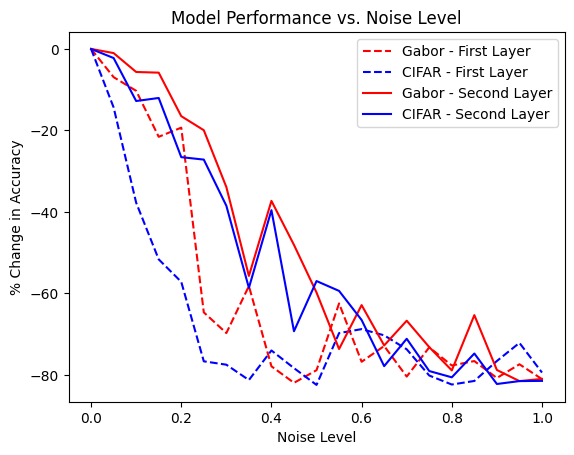

In [57]:
import seaborn as sns
sns.lineplot(data=noise_results_df, x='noise_level', y='noisy1_gabor_pctchange', label='Gabor - First Layer', color='red', linestyle='--')
sns.lineplot(data=noise_results_df, x='noise_level', y='noisy1_cifar_pctchange', label='CIFAR - First Layer', color='blue', linestyle='--')

sns.lineplot(data=noise_results_df, x='noise_level', y='noisy2_gabor_pctchange', label='Gabor - Second Layer', color='red')
sns.lineplot(data=noise_results_df, x='noise_level', y='noisy2_cifar_pctchange', label='CIFAR - Second Layer', color='blue')

plt.xlabel('Noise Level')
plt.ylabel('% Change in Accuracy')
plt.title('Model Performance vs. Noise Level')
plt.legend()

In [36]:
#### stability plots ####
results = {
    'idx': [],
    'gabor_acc': [],
    'cifar_acc': [],
}

noise_results = {
    'idx': [],
    'noise_level': [],
    'noisy1_gabor_acc': [],
    'noisy1_cifar_acc': [],
    'noisy2_gabor_acc': [],
    'noisy2_cifar_acc': [],
}
noise_levels = np.arange(0, 1.05, 0.05)

for i in range(20):
    model = modeling.ConvNet(in_channels=1, height=32, width=32)
    model, losses, val_losses, _, _, _, _ = modeling.train_model(
        model, 
        combined_loader, 
        val_dataset=combined_valset, 
        batch_size=64, 
        probe_size=64, 
        num_epochs=50, 
        early_stopping=True
    )

    gabor_acc = modeling.evaluate_gabor_accuracy(model, gabor_test_loader)
    cifar_acc = modeling.evaluate_cifar_accuracy(model, cifar_test_loader)

    results['idx'].append(i)
    results['gabor_acc'].append(gabor_acc)
    results['cifar_acc'].append(cifar_acc)

    for noise in noise_levels:
        noisy_model = copy.deepcopy(model)

        noisy_first_model = modeling.add_noise_to_first_layer(noisy_model, noise_level=noise)
        noisy1_gabor_acc = modeling.evaluate_gabor_accuracy(noisy_model, gabor_test_loader)
        noisy1_cifar_acc = modeling.evaluate_cifar_accuracy(noisy_model, cifar_test_loader)

        noisy_model = copy.deepcopy(model)
        noisy_middle_model = modeling.add_noise_to_middle_layer(noisy_model, noise_level=noise)
        noisy2_gabor_acc = modeling.evaluate_gabor_accuracy(noisy_model, gabor_test_loader)
        noisy2_cifar_acc = modeling.evaluate_cifar_accuracy(noisy_model, cifar_test_loader)

        noise_results['idx'].append(i)
        noise_results['noise_level'].append(noise)
        noise_results['noisy1_gabor_acc'].append(noisy1_gabor_acc)
        noise_results['noisy1_cifar_acc'].append(noisy1_cifar_acc)
        noise_results['noisy2_gabor_acc'].append(noisy2_gabor_acc)
        noise_results['noisy2_cifar_acc'].append(noisy2_cifar_acc)
    
    print(f'Iteration {i+1}/10 complete.')

Training model with tag: 2025_10_17_19:00:25


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6112Validation Loss: 4.6086


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 1.9390Validation Loss: 2.1072


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.7722Validation Loss: 2.0454


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6099Validation Loss: 2.0156


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.4641Validation Loss: 1.9975
Early stopping triggered: validation loss increased significantly 1.9975 -> 2.0483.
Iteration 1/10 complete.
Training model with tag: 2025_10_17_19:02:06


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6138Validation Loss: 4.6140


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 1.9660Validation Loss: 2.1403


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.7683Validation Loss: 2.0562


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6214Validation Loss: 2.0107


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.4556Validation Loss: 1.9871
Early stopping triggered: validation loss increased significantly 1.9871 -> 2.0766.
Iteration 2/10 complete.
Training model with tag: 2025_10_17_19:03:46


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6201Validation Loss: 4.6214


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 2.0029Validation Loss: 2.1570


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.7740Validation Loss: 2.0505


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6309Validation Loss: 2.0303


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.4963Validation Loss: 2.0086
Early stopping triggered: validation loss increased significantly 2.0086 -> 2.0908.
Iteration 3/10 complete.
Training model with tag: 2025_10_17_19:05:27


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6199Validation Loss: 4.6208


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 2.0366Validation Loss: 2.2029


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.7501Validation Loss: 2.0354


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6057Validation Loss: 2.0260


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.4739Validation Loss: 2.0044


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.3521Validation Loss: 1.9962
Early stopping triggered: validation loss increased significantly 1.9962 -> 2.0942.
Iteration 4/10 complete.
Training model with tag: 2025_10_17_19:07:22


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6134Validation Loss: 4.6133


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 1.9657Validation Loss: 2.1278


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.7686Validation Loss: 2.0536


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6220Validation Loss: 2.0219


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.5084Validation Loss: 2.0219


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.4176Validation Loss: 2.0501


Batches in epoch #7:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [7/50]Training Loss: 1.3152Validation Loss: 2.0616


Batches in epoch #8:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [8/50]Training Loss: 1.2297Validation Loss: 2.1031
Early stopping triggered: validation loss increased significantly 2.1031 -> 2.1771.
Iteration 5/10 complete.
Training model with tag: 2025_10_17_19:09:45


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6129Validation Loss: 4.6101


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 2.0344Validation Loss: 2.2188


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.7429Validation Loss: 2.0361


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6522Validation Loss: 2.0532


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.4999Validation Loss: 2.0257


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.3803Validation Loss: 2.0301
Early stopping triggered: validation loss increased significantly 2.0301 -> 2.1049.
Iteration 6/10 complete.
Training model with tag: 2025_10_17_19:11:40


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6156Validation Loss: 4.6143


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 1.9254Validation Loss: 2.0973


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.7365Validation Loss: 2.0101


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6171Validation Loss: 2.0208


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.4895Validation Loss: 2.0032


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.3833Validation Loss: 2.0025
Early stopping triggered: validation loss increased significantly 2.0025 -> 2.0569.
Iteration 7/10 complete.
Training model with tag: 2025_10_17_19:13:35


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6090Validation Loss: 4.6095


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 1.9905Validation Loss: 2.1491


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.8020Validation Loss: 2.0694


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6341Validation Loss: 2.0195


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.5430Validation Loss: 2.0495


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.4221Validation Loss: 2.0473


Batches in epoch #7:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [7/50]Training Loss: 1.3114Validation Loss: 2.0546


Batches in epoch #8:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [8/50]Training Loss: 1.1992Validation Loss: 2.0787
Early stopping triggered: validation loss increased significantly 2.0787 -> 2.1738.
Iteration 8/10 complete.
Training model with tag: 2025_10_17_19:15:58


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6157Validation Loss: 4.6145


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 2.0293Validation Loss: 2.1886


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.8199Validation Loss: 2.0759


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6229Validation Loss: 1.9805


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.5514Validation Loss: 2.0254


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.4008Validation Loss: 2.0136


Batches in epoch #7:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [7/50]Training Loss: 1.3383Validation Loss: 2.0475


Batches in epoch #8:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [8/50]Training Loss: 1.2157Validation Loss: 2.0600
Early stopping triggered: validation loss increased significantly 2.0600 -> 2.1232.
Iteration 9/10 complete.
Training model with tag: 2025_10_17_19:18:20


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6141Validation Loss: 4.6161


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 2.0064Validation Loss: 2.1762


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.7593Validation Loss: 2.0483


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.5909Validation Loss: 2.0044
Early stopping triggered: validation loss increased significantly 2.0044 -> 2.0802.
Iteration 10/10 complete.
Training model with tag: 2025_10_17_19:19:47


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6254Validation Loss: 4.6236


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 2.0181Validation Loss: 2.1656


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.8072Validation Loss: 2.0692


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6555Validation Loss: 2.0340


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.5226Validation Loss: 2.0127


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.3748Validation Loss: 1.9885
Early stopping triggered: validation loss increased significantly 1.9885 -> 2.1107.
Iteration 11/10 complete.
Training model with tag: 2025_10_17_19:21:42


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6239Validation Loss: 4.6250


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 2.0340Validation Loss: 2.1851


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.8056Validation Loss: 2.0647


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6689Validation Loss: 2.0456


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.5864Validation Loss: 2.0606


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.4332Validation Loss: 2.0134
Early stopping triggered: validation loss increased significantly 2.0134 -> 2.1178.
Iteration 12/10 complete.
Training model with tag: 2025_10_17_19:23:36


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6145Validation Loss: 4.6148


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 2.0116Validation Loss: 2.1817


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.7886Validation Loss: 2.0644


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6420Validation Loss: 2.0245


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.5283Validation Loss: 2.0233


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.3656Validation Loss: 2.0058
Early stopping triggered: validation loss increased significantly 2.0058 -> 2.0602.
Iteration 13/10 complete.
Training model with tag: 2025_10_17_19:25:30


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6100Validation Loss: 4.6098


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 1.9889Validation Loss: 2.1439


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.7404Validation Loss: 2.0142


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6698Validation Loss: 2.0424


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.5391Validation Loss: 2.0407


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.3951Validation Loss: 2.0254


Batches in epoch #7:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [7/50]Training Loss: 1.2983Validation Loss: 2.0606


Batches in epoch #8:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [8/50]Training Loss: 1.2169Validation Loss: 2.0874
Early stopping triggered: validation loss increased significantly 2.0874 -> 2.1753.
Iteration 14/10 complete.
Training model with tag: 2025_10_17_19:27:53


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6249Validation Loss: 4.6254


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 2.0304Validation Loss: 2.1911


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.8060Validation Loss: 2.0624


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6869Validation Loss: 2.0646


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.5570Validation Loss: 2.0637


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.4054Validation Loss: 2.0142
Early stopping triggered: validation loss increased significantly 2.0142 -> 2.1333.
Iteration 15/10 complete.
Training model with tag: 2025_10_17_19:29:48


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6204Validation Loss: 4.6188


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 1.9631Validation Loss: 2.1282


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.7803Validation Loss: 2.0624


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6552Validation Loss: 2.0366


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.5301Validation Loss: 2.0322


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.4009Validation Loss: 2.0624


Batches in epoch #7:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [7/50]Training Loss: 1.2880Validation Loss: 2.0796


Batches in epoch #8:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [8/50]Training Loss: 1.1939Validation Loss: 2.1239


Batches in epoch #9:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [9/50]Training Loss: 1.1159Validation Loss: 2.1604


Batches in epoch #10:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [10/50]Training Loss: 1.0209Validation Loss: 2.2068
Early stopping triggered: validation loss increased significantly 2.2068 -> 2.3039.
Iteration 16/10 complete.
Training model with tag: 2025_10_17_19:32:38


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6134Validation Loss: 4.6139


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 1.9933Validation Loss: 2.1483


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.7697Validation Loss: 2.0353


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6001Validation Loss: 1.9857


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.4750Validation Loss: 1.9787
Early stopping triggered: validation loss increased significantly 1.9787 -> 2.1242.
Iteration 17/10 complete.
Training model with tag: 2025_10_17_19:34:19


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6193Validation Loss: 4.6155


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 2.0375Validation Loss: 2.2108


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.8161Validation Loss: 2.0909


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6431Validation Loss: 2.0428


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.5214Validation Loss: 2.0524


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.3390Validation Loss: 1.9942


Batches in epoch #7:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [7/50]Training Loss: 1.2338Validation Loss: 2.0261
Early stopping triggered: validation loss increased significantly 2.0261 -> 2.1714.
Iteration 18/10 complete.
Training model with tag: 2025_10_17_19:36:27


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6243Validation Loss: 4.6234


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 2.0644Validation Loss: 2.2312


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.8402Validation Loss: 2.1124


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6340Validation Loss: 2.0190


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.5316Validation Loss: 2.0438


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.4299Validation Loss: 2.0626


Batches in epoch #7:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [7/50]Training Loss: 1.3367Validation Loss: 2.1073


Batches in epoch #8:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [8/50]Training Loss: 1.1822Validation Loss: 2.0773
Early stopping triggered: validation loss increased significantly 2.0773 -> 2.1649.
Iteration 19/10 complete.
Training model with tag: 2025_10_17_19:38:50


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6059Validation Loss: 4.6056


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 1.9886Validation Loss: 2.1429


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.7607Validation Loss: 2.0281


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6079Validation Loss: 1.9848


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.4825Validation Loss: 1.9848


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.3685Validation Loss: 2.0026
Early stopping triggered: validation loss increased significantly 2.0026 -> 2.0832.
Iteration 20/10 complete.


In [37]:
import pandas as pd
noise_results_df = pd.DataFrame(noise_results)
noise_results_df

,idx,noise_level,noisy1_gabor_acc,noisy1_cifar_acc,noisy2_gabor_acc,noisy2_cifar_acc
0,0,0.00,60.72,61.58,60.72,61.58
1,0,0.05,59.27,43.77,60.59,61.24
2,0,0.10,51.70,32.50,60.04,58.70
3,0,0.15,48.84,29.68,58.94,48.80
4,0,0.20,37.39,17.38,55.10,46.73
...,...,...,...,...,...,...
415,19,0.80,11.65,12.46,23.18,13.65
416,19,0.85,18.67,16.45,24.42,14.38
417,19,0.90,11.68,9.47,19.64,17.49
418,19,0.95,16.07,13.28,26.38,14.20


(0.0, 63.70556679024193)

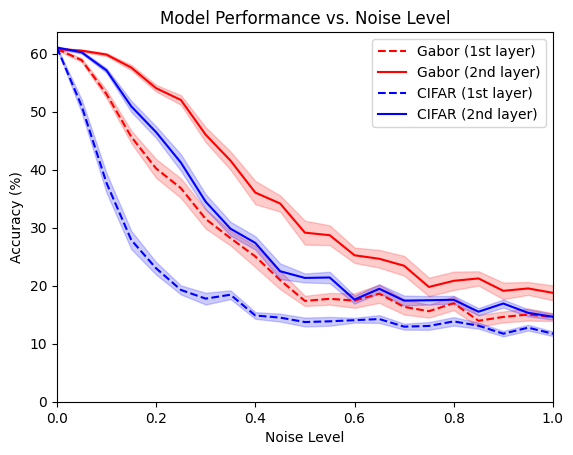

In [38]:
import seaborn as sns

sns.lineplot(
    data=noise_results_df, 
    x='noise_level', 
    y='noisy1_gabor_acc', 
    err_style='band',
    errorbar='se',
    markers='o',
    linestyle='--',
    color='red',
    label='Gabor (1st layer)'
    )

sns.lineplot(
    data=noise_results_df, 
    x='noise_level', 
    y='noisy2_gabor_acc', 
    err_style='band',
    errorbar='se',
    markers='o',
    color='red',
    label='Gabor (2nd layer)'
    )

sns.lineplot(
    data=noise_results_df, 
    x='noise_level', 
    y='noisy1_cifar_acc', 
    err_style='band',
    errorbar='se',
    color='blue',
    linestyle='--',
    label='CIFAR (1st layer)'
    )

sns.lineplot(
    data=noise_results_df, 
    x='noise_level', 
    y='noisy2_cifar_acc', 
    err_style='band',
    errorbar='se',
    color='blue',
    label='CIFAR (2nd layer)'
    )

plt.xlabel('Noise Level')
plt.ylabel('Accuracy (%)')
plt.title('Model Performance vs. Noise Level')
# plt.legend(['Gabor Accuracy', '', 'CIFAR Accuracy', ''])
plt.legend()
plt.xlim(0, 1)
plt.ylim(bottom=0)

In [41]:
pct_change_dfs = []

for i in range(10):
    temp_df = noise_results_df[noise_results_df['idx'] == i]
    temp_df['noisy1_gabor_pctchange'] = (temp_df['noisy1_gabor_acc'] - temp_df['noisy1_gabor_acc'].iloc[0]) / temp_df['noisy1_gabor_acc'].iloc[0] * 100
    temp_df['noisy2_gabor_pctchange'] = (temp_df['noisy2_gabor_acc'] - temp_df['noisy2_gabor_acc'].iloc[0]) / temp_df['noisy2_gabor_acc'].iloc[0] * 100
    temp_df['noisy1_cifar_pctchange'] = (temp_df['noisy1_cifar_acc'] - temp_df['noisy1_cifar_acc'].iloc[0]) / temp_df['noisy1_cifar_acc'].iloc[0] * 100
    temp_df['noisy2_cifar_pctchange'] = (temp_df['noisy2_cifar_acc'] - temp_df['noisy2_cifar_acc'].iloc[0]) / temp_df['noisy2_cifar_acc'].iloc[0] * 100

    pct_change_dfs.append(temp_df)

pct_change_df = pd.concat(pct_change_dfs)

/tmp/ipykernel_1818885/3439499917.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['noisy1_gabor_pctchange'] = (temp_df['noisy1_gabor_acc'] - temp_df['noisy1_gabor_acc'].iloc[0]) / temp_df['noisy1_gabor_acc'].iloc[0] * 100
/tmp/ipykernel_1818885/3439499917.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['noisy2_gabor_pctchange'] = (temp_df['noisy2_gabor_acc'] - temp_df['noisy2_gabor_acc'].iloc[0]) / temp_df['noisy2_gabor_acc'].iloc[0] * 100
/tmp/ipykernel_1818885/3439499917.py:7: Sett

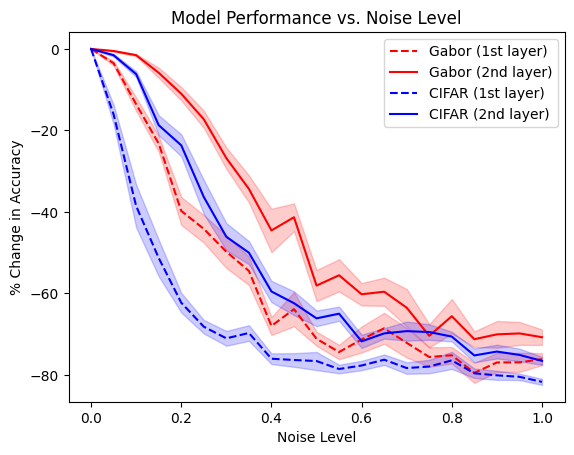

In [44]:
import seaborn as sns

sns.lineplot(
    data=pct_change_df, 
    x='noise_level', 
    y='noisy1_gabor_pctchange', 
    err_style='band',
    errorbar='se',
    markers='o',
    linestyle='--',
    color='red',
    label='Gabor (1st layer)'
    )

sns.lineplot(
    data=pct_change_df, 
    x='noise_level', 
    y='noisy2_gabor_pctchange', 
    err_style='band',
    errorbar='se',
    markers='o',
    color='red',
    label='Gabor (2nd layer)'
    )

sns.lineplot(
    data=pct_change_df, 
    x='noise_level', 
    y='noisy1_cifar_pctchange', 
    err_style='band',
    errorbar='se',
    color='blue',
    linestyle='--',
    label='CIFAR (1st layer)'
    )

sns.lineplot(
    data=pct_change_df, 
    x='noise_level', 
    y='noisy2_cifar_pctchange', 
    err_style='band',
    errorbar='se',
    color='blue',
    label='CIFAR (2nd layer)'
    )

plt.xlabel('Noise Level')
plt.ylabel('% Change in Accuracy')
plt.title('Model Performance vs. Noise Level')
# plt.legend(['Gabor Accuracy', '', 'CIFAR Accuracy', ''])
plt.legend()
# plt.xlim(0, 1)
# plt.ylim(bottom=-10)